# 综合不同模型的组合学习

本章内容主要涵盖下述几个方面：
* 以多数票机制为基础做出预测
* 使用套袋通过反复从训练集可重复地随即抽取样本组合减少过拟合
* 利用激励，在从错误中学习地若学习者的基础上建立强大的模型

## 集成学习

__集成学习__的目标是组合不同的分类器，形成比单个分类器具有更好泛化性能的元分类器。

本章将集中讨论最常见的基与__多数票机制__的集成方法。

为了通过简单的多数票或相对多数票投票机制预测分类标签，可以把每个单独的分类器$C_j$预测的分类标签组合起来，然后选择分类标签$\hat{y}$，从而得到的票做多的标签：

$$\hat{y}=mode{C_1(x),C_2(x),\ldots,C_m(x)}$$

假设所有$n$个基本分类器所面对的都是二元分类任务，错误率$\varepsilon$相同。另外，假设分类器都是独立的而且错误率互不相干。在这些假设条件下，可以直接把基本分类器集成的错误率表达为二项式分布的概率质量函数：

$$P(y\ge k)=\sum_k^n C_k^n \varepsilon^k (1-\varepsilon)^{n-k}=\varepsilon_{ensemble}$$

In [5]:
from scipy.special import comb
import math
def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier,k) * 
             error**k * 
             (1-error)**(n_classifier - k)
             for k in range(k_start, n_classifier+1)]
    return sum(probs)

ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

在实现了ensemble_error函数后，可以计算从0.0到1.0的范围内内的不同集成错误率，并绘图。

只要基本分类器的性能优于随机猜想（$\varepsilon < 0.5$），集成分类器的错误率总是比单一基本分类器的错误率要低。

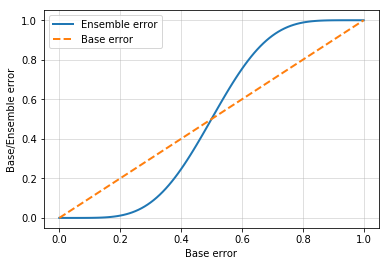

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
error_range = np.arange(0.0,1.01,0.01)
ens_error = [ensemble_error(n_classifier=11,error=error)
             for error in error_range]
plt.plot(error_range,ens_error,
         label='Ensemble error',
         linewidth=2)
plt.plot(error_range,error_range,
         linestyle='--',label='Base error',
         linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

## 采用多数票机制的集成分类器

### 实现基于多数票的简单分类器

本节将要实现的算法可以把不同的分类算法及其各自相应的权重组合起来。目标是建立一个更强大的超级分类器，以平衡单个分类器在特定数据集上的弱点。可以利用更精确的数学语言把加权多数票的逻辑表示如下：

$$\hat{y}=\arg \max\limits_i \sum_{j=1}^m w_j \chi_A(C_j(x)=i)$$

这里$w_j$是与基本分类器$C_j$相关的权重，$\hat{y}$是分类标签的预测结果，$\chi_A$是特性函数$[C_j(x)=i \in A]$，$A$为独立分类标签的集合。对于相同权重，可以把该方程简化为：

$$\hat{y}=mode {C_1(x),C_2(x),\ldots,C_m(x)}$$

可以用Numpy的argmax和bincount函数将加权大多数票概念翻译成Python代码

In [7]:
import numpy as np
np.argmax(np.bincount([0,0,1],
          weights=[0.2,0.2,0.6]))

1

如果集成分类预测的够准确，用预测的分类概率代替分类标签进行大多数票表决是有用的。

$$\hat{y}=\arg\max\limits_i\sum_{j=1}^mw_jp_{ij}$$

这里，$p_{ij}$为第$j$个分类器对分类标签$i$预测的概率。

In [8]:
ex = np.array([[0.9,0.1],
               [0.8,0.2],
               [0.4,0.6]])
p = np.average(ex,axis=0,weights=[0.2,0.2,0.6])
p
np.argmax(p)

0

In [9]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator,
                              ClassifierMixin):
    """ A majority vote ensemble classifier
    
    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
        Different classifiers for the ensemble
    vote : str, {'classlabel','probability'}
        Default: 'classlabel'
        If 'classlabel' the prediction is based on
        the argmax of class labels. Else if
        'probability', the argmax of the sum of
        probability is used to predict the class label
        (recommended for calibrated classifiers).
    weights : array-like, shape = [n_classifiers]
        Optional, default: None
        If a list if 'int' or 'float' values are
        provided, the classifiers are weighted by
        importance; Uses uniform weights if 'weights=None'.
    """
    def __init__(self,classifiers,
                  vote='classlabel',weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for
                                  key, value in
                                  _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self,X,y):
        """Fit classifiers.
        
        Parameters
        ----------
        X : {array-like, spares matrix},
            shape = [n_samples, n_features]
            Matrix of training samples.
        y : array-like, shape = [n_features]
            Vecor of target class labels.
            
        Returns
        ----------
        self : object
        """ 
        # Use LabelEncoder to ensure class labels start
        # with 0, which is important for np.argmax
        # call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X,
                                self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self,X):
        """ Predict class labels for X.
        
        Parameters
        ----------
        X : {array-like, sparse matrix},
            Shape = [n_samples, n_features]
            Matrix of training samples.
        
        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predic_proba(X),
                                 axis=1)
        else: # 'classlabel' vote
            # Collect results from clf.predict calls
            predictions = np.asarray([clf.predice(X)
                                      for clf in
                                      self.classifiers_]).T
            maj_vote = np.apply_along_axis(
                        lambda x:
                        np.argmax(np.bincount(x,
                                  weights=self.weights)),
                        axis=1,
                        arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self,X):
        """ Predict class probabilities for X.
        
        Parameters
        ----------
        X : {array-like, sparese matrix},
            shape = {n_samples, n_features}
            Training vectors, where n_samples is
            the number of samples and
            n_features is the number of features.
            
        Returns
        ----------
        avg_proba : array-like,
            shape = [n_samples, n_classes]
            Weighted average probability for
            each class per sample.
        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas,
                               axis=0,weights=self.weights)
        return avg_proba
    
    def get_params(self,deep=True):
        """Get classifier parameteer names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier,
                          self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in\
                    six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(
                    step.get_params(deep=True)):
                    out['%s_%s' % (name,key)] = value
        return out

这里定义了我们自己修改后的get_params方法来使用_name_estimators函数访问集成分类器中每个成员分类器的参数。这可能看似复杂，但却特别有用。特别是在以后的章节中用网格搜索寻找调优的超参数时。

### 用多数票原则进行预测

In [11]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
iris = datasets.load_iris()
X,y = iris.data[50:,[1,2]],iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train,X_test,y_train,y_test = \
        train_test_split(X,y,
                         test_size=0.5,
                         random_state=1,
                         stratify=y)

现在将使用训练集训练三种不同分类器：
* 逻辑回归分类器
* 决策树分类器
* k-近邻分类器

在将它们构建成分类器之前，先通过对训练集进行10次交叉验证以评估每个分类器模型的性能

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty='l2',
                          C=0.001,
                          solver='lbfgs',
                          random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc',StandardScaler()],
                  ['clf',clf1]])
pipe3 = Pipeline([['sc',StandardScaler()],
                  ['clf',clf3]])
clf_labels = ['Logistic regression','Decision tree','KNN']
print('10-fold cross validation:\n')
for clf, label in zip([pipe1,clf2,pipe3],clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print('ROC AUC: %0.2f (+/- %0.2f) [%s]'
          % (scores.mean(),scores.std(),label))

10-fold cross validation:

ROC AUC: 0.87 (+/- 0.17) [Logistic regression]
ROC AUC: 0.89 (+/- 0.16) [Decision tree]
ROC AUC: 0.88 (+/- 0.15) [KNN]


与决策树相比，逻辑回归和k近邻算法都是比例尺度可变的，采用标准化特征是一个好习惯。

现在开始更精彩的部分，在MajorityVoteClassifier类中集成独立的分类器进行多数票决策

In [14]:
mv_clf = MajorityVoteClassifier(
                classifiers=[pipe1,clf2,pipe3])
clf_labels += ['Majority voting']
all_clf = [pipe1,clf2,pipe3,mv_clf]
for clf, label in zip(all_clf,clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print('Accuracy: %0.2f (+/- %0.2f) [%s]'
              % (scores.mean(),scores.std(),label))

Accuracy: 0.87 (+/- 0.17) [Logistic regression]
Accuracy: 0.89 (+/- 0.16) [Decision tree]
Accuracy: 0.88 (+/- 0.15) [KNN]
Accuracy: 0.94 (+/- 0.13) [Majority voting]
